## Southern Ocean decadal variability

Assess the decadal variability of water mass transformation in the Southern Ocean, and relate it to changes in the overturning circulation.

In [153]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from xhistogram.xarray import histogram
from xgcm import Grid
from numba import jit
import glob
%matplotlib inline

### Load the data

In [154]:
rootdir = '/local/projects/so_decadal_variability/'
localdir = ''
prefix = 'SO_'
grid_name = 'en4'
ocean_name = 'en4'
flux_name = 'erai'
ocean_suffix = '_197901-201812.nc'
flux_suffix = '_1979-2018.nc'
grid_suffix = '.nc'
# Ocean data
filename = prefix+'ocean_*'+ocean_name+ocean_suffix
ocean = xr.open_mfdataset(rootdir+localdir+'ocean/'+filename)
# Flux data (more complicated loading because of muddled time coordinate)
fluxfiles=[]
filename = prefix+'flux_*'+flux_name+'_'+ocean_name+flux_suffix
for file in glob.glob(rootdir+'flux/'+filename):
    f = file[-24:-22]
    if f in ['sr','fw','ht']:
        fluxfiles.append(file)
flux = xr.open_mfdataset(fluxfiles).assign_coords({'time':ocean['time']})
# Grid data
filename = prefix+'grid_*'+grid_name+grid_suffix
grid = xr.open_mfdataset(rootdir+'grid/*'+filename)
ds = xr.merge([ocean,flux,grid])
# Mate heat flux positive into the ocean
ds['ht'] *= -1
ds['sr'] *= -1
# Turn gamman to a proper density
ds['gamman']+=1000

### Create xgcm object

In [155]:
@jit(nopython=True)
def haversine_distance(lat1,lat2,lon1,lon2,degrees=True):
    R=6371E3
    if degrees:
        fac = np.pi/180
        lat1 = lat1*fac
        lat2 = lat2*fac
        lon1 = lon1*fac
        lon2 = lon2*fac
    return 2*R*np.arcsin(np.sqrt(np.sin((lat2-lat1)/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin((lon2-lon1)/2)**2))

@jit(nopython=True)
def calc_spacing_from_latlon(lat,lon):
    ni = len(lon)-1
    nj = len(lat)-1
    dx = np.empty(shape=(ni,nj))
    dy = np.empty(shape=(ni,nj))
    for i in range(ni):
        lon1 = lon[i]
        lon2 = lon[i+1]
        for j in range(nj):
            lat1 = lat[j]
            lat2 = lat[j+1]

            dx[i,j] = haversine_distance(lat1,
                                         lat1,
                                         lon1,
                                         lon2,
                                         degrees=True)
            dy[i,j] = haversine_distance(lat1,
                                         lat2,
                                         lon1,
                                         lon1,
                                         degrees=True)
    return dx, dy

In [156]:
# Specify coordinates with ghost points
lonG = np.append(ds['lon']+0.5,ds['lon'][-1]+1.5,)
latG = np.append(ds['lat']+0.5,ds['lat'][-1]+1.5,)
latC = np.append(ds['lat'],ds['lat'][-1]+1)
lonC = np.append(ds['lon'],ds['lon'][-1]+1)
# Find distances
# ... across cell faces
dxC,_ = calc_spacing_from_latlon(latC,lonG) # defined at latC,lonC
_,dyC = calc_spacing_from_latlon(latG,lonC) # defined at latC,lonC
# ... between grid cell boundaries
dxG,dyG = calc_spacing_from_latlon(latC,lonC) # defined at latC,lonG & latG,lonC
# Specify cell boundary coordinates
ds['lonG'] = xr.DataArray(lonG[:-1],dims=['lonG'])
ds['latG'] = xr.DataArray(latG[:-1],dims=['latG'])
# Specify grid spacings
ds['dxC'] = xr.DataArray(dxC,dims=['lon','lat'])
ds['dyC'] = xr.DataArray(dyC,dims=['lon','lat'])
ds['dxG'] = xr.DataArray(dxG,dims=['lonG','lat'])
ds['dyG'] = xr.DataArray(dyG,dims=['lon','latG'])
# Find depths of outer points
depth_i_vals = np.append(grid.depth_bnds.isel(bnds=0), grid.depth_bnds.isel(bnds=1)[-1])
ds['depth_i'] = xr.DataArray(depth_i_vals,coords={'depth_i':depth_i_vals},dims={'depth_i'})
# Get depth distance
ds['dz'] = ds['depth_i'].diff('depth_i').rename({'depth_i':'depth'}).assign_coords({'depth':ds['depth']})

In [157]:
coords = {
    'X':{'center':'lon','right':'lonG'},
    'Y':{'center':'lat','right':'latG'},
    'Z':{'center':'depth','outer':'depth_i'}
}
metrics = {
    'X':['dxC','dxG'],
    'Y':['dyC','dyG'],
    'Z':['dz']
}
xgrid = Grid(ds,coords=coords,metrics=metrics,periodic=['X'])

## Depth penetration of shortwave radiation

Use empirical exponential decay function of Paulson and Simpson (1977)
$$ F_{PS77}(z) = R\ e^{-\frac{z}{h_1}}+(1-R)e^{-\frac{z}{h_2}} $$
where $R = 0.58$, $h_1 = 0.35m$, and $h_2 = 23m$.

In [158]:
R = 0.58
h1 = 0.35
h2 = 23

# Calculate in 1D
Fps77 = R*np.exp(-ds['depth_i']/h1)+(1-R)*np.exp(-ds['depth_i']/h2)

# Now get a 4D shortwave field
ds['sr4d'] = ds['sr']*Fps77
# and take the divergence
# (note that for taking the derivative, 'depth' must be positive upward, so reverse the sign)
# (subsequently, reverse the sign so that it is consistent with the other variables)
ds['dsr4d'] = xgrid.derivative(-ds['sr4d'],'Z')

## b-factor

From Jacket and McDougall (2005):
$$ b = \frac{|\nabla \gamma^n|}{|\nabla \rho_l|} $$

From Groeskamp et al. (2018):
$$ \nabla \rho_l = \rho (-\alpha\nabla \Theta + \beta \nabla S_A)$$
where $\rho$ is _in situ_ density.

- The b-factor for EN4 data is now calculated in the script `calc_b-factor_EN4`, and loaded with all the other data at the start of this notebook

## Water mass transformation calculation

From Groeskamp and Iudicone (2018), transformation across a $\gamma^n$ surface is given by:
$$ G(\gamma^n) = \frac{\partial}{\partial \gamma^n}\iiint_{\hat{\gamma^n}\leq\gamma^n} \hat{\gamma^n}\ b\ F\ dV $$

We utilise the discrete volume formulation derived in Groeskamp et al. (2019), Appendix 7.5, Eq. 48  
TO FILL IN EQUATION

The surface density flux, $F$, is given by:
$$ F = \big[-(E+P+R)S_A\beta + \frac{\alpha}{C_p}(Q_{lw}+Q_{lh}+Q_{sh})\big]\delta(z-\eta) + \frac{\alpha}{C_p}\nabla \cdot Q_{sw} F(z) $$
where $F(z)$ describes the vertical penetration of incoming shortwave radiation. Freshwater fluxes are _positive_ into the ocean, heat fluxes are _positive_ into the atmosphere.

In [159]:
def calc_F(FW,Q,Qsw,S,alpha,beta,Cp=4200):
    
    Fheat = (alpha/Cp)*Q + (alpha/Cp)*Qsw
    Ffw = -FW*S*beta
    F = Fheat+Ffw
    
    F.name = 'F'
    Fheat.name = 'Fheat'
    Ffw.name = 'Ffw'
    
    return F, Fheat, Ffw

In [160]:
# Create a 3D mask with 1/dz in the surface and zero elsewhere
idz = 1/ds['dz'][0].values
mask = xr.concat([idz*xr.ones_like(ds['ct'].isel(time=0,depth=0)),
                  xr.zeros_like(ds['ct'].isel(time=0,depth=slice(1,None)))],
                 dim='depth')

# Calculate density flux
F,Fheat,Ffw = calc_F(ds['fw']*mask,ds['ht']*mask,ds['dsr4d'],ds['sa'],ds['alpha'],ds['beta'])

Plot the density change due to heat and freshwater forcing

KeyboardInterrupt: 

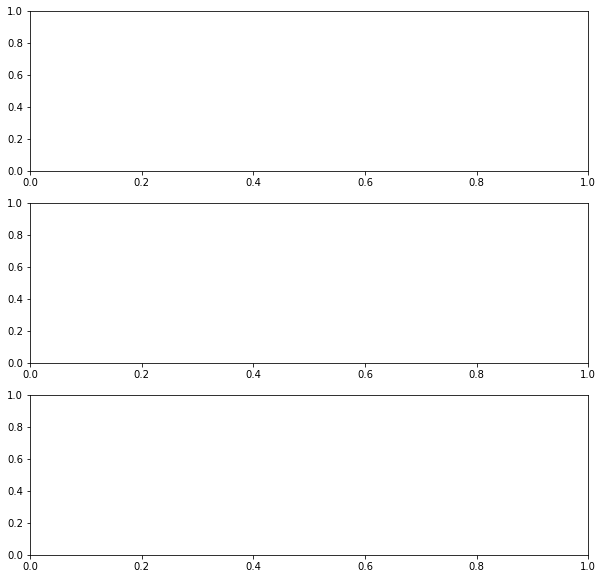

In [79]:
fig,ax = plt.subplots(figsize=(10,10),nrows=3)
im=ax[0].pcolormesh((F*ds['dz']).sum('depth').mean('time'),cmap='RdBu',vmin=-1E-5,vmax=1E-5)
plt.colorbar(im,ax=ax[0])
im=ax[1].pcolormesh((Fheat*ds['dz']).sum('depth').mean('time'),cmap='RdBu',vmin=-1E-5,vmax=1E-5)
plt.colorbar(im,ax=ax[1])
im=ax[2].pcolormesh((Ffw*ds['dz']).sum('depth').mean('time'),cmap='RdBu',vmin=-1E-5,vmax=1E-5)
plt.colorbar(im,ax=ax[2])

In [161]:
# Discrete volume calculation derived in Appendix 7.5 of Groeskamp et al (2018)
def calc_G(F,gamman,b,V,gn_edges):
    gFbV = gamman*b*F*V
    nanmask=np.isnan(gFbV)
    G = histogram(gamman.where(~nanmask),bins=[gn_edges],weights=gFbV.where(~nanmask),dim=['lat','lon','depth'])/np.diff(gn_edges)
    return G

In [162]:
# Calculate G
gn_edges = np.arange(1026,1028.5,0.1)
G = xr.Dataset()
G['G_heat'] = calc_G(Fheat,ds['gamman'],ds['b'],ds['vol4d'],gn_edges)
G['G_fw'] = calc_G(Ffw,ds['gamman'],ds['b'],ds['vol4d'],gn_edges)
G['G'] = calc_G(F,ds['gamman'],ds['b'],ds['vol4d'],gn_edges)

In [121]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    G.load()

[########################################] | 100% Completed | 29.9s


Text(0, 0.5, 'water mass transformation (10^9 kg s^-1)')

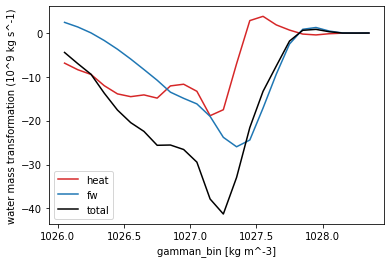

In [122]:
(G['G_heat']*1E-9).mean('time').plot(label='heat',color='tab:red')
(G['G_fw']*1E-9).mean('time').plot(label='fw',color='tab:blue')
(G['G']*1E-9).mean('time').plot(label='total',color='k')
plt.legend()
plt.ylabel('water mass transformation (10^9 kg s^-1)')

Take annual means and remove time-mean signal

In [123]:
def calc_annualanom(da):
    annual = da.coarsen(time=12,boundary='trim').mean()
    mean = da.mean('time')*xr.ones_like(annual)
    annualanom = annual-mean
    return annualanom

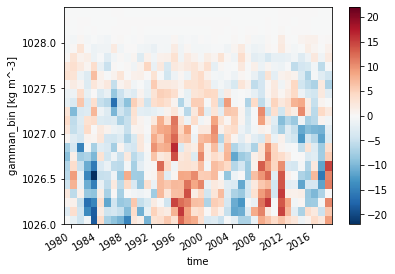

In [125]:
Gannualanom = calc_annualanom(G['G'])
(Gannualanom*1E-9).transpose().plot();

## Calculate dM/dt

In [163]:
gn_edges = np.array([ds['gamman'].min(xr.ALL_DIMS),G['gamman_bin'].values,ds['gamman'].max(xr.ALL_DIMS)])

/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [191]:
# Get min and max gamma values
mx = [ds['gamman'].max().values]
mn = [ds['gamman'].min().values]

In [200]:
ds['mass'] = ds['rho']*ds['vol4d']
# The boundaries for the mass integral correspond to the central value from
# the calculation of G, plus, they need to incorporate the full density range
gn_edges = np.concatenate((mn,G['gamman_bin'].values,mx))
nanmask=np.isnan(ds['gamman'])
M_on_gamma = histogram(ds['gamman'].where(~nanmask),
                       bins=[gn_edges],
                       weights=ds['mass'].where(~nanmask),
                       dim=['lat','lon','depth']).transpose()

# To integrate for all volume with temperature greater than a certain value,
# take cumulative sum and reassign the coordinates to align with G
M_on_gamma_cumsum = xr.concat([xr.zeros_like(M_on_gamma.isel({'gamman_bin':0})),
                               M_on_gamma.cumsum('gamman_bin')],dim='gamman_bin')
# We wish to have the total mass for the volume with temperature greater than that contour,
# So take away the total sum from the cumulative sum to reverse the direction
M_reverse = (M_on_gamma.sum('gamman_bin')-M_on_gamma_cumsum)
# Now we can get rid of the boundary contours, which were there to ensure that all
# of the volume wass captures, and we assign the coordinates to match with G
M = M_reverse.isel(gamman_bin=slice(1,-1)).assign_coords({'gamman_bin':G['gamman_bin']})

# Calculate the derivative with respect to time
dMdt = M.diff('time')/(M['time'].diff('time').astype('float')*1E-9)
# The time derivative is align with the start of each month,
# so define a new time coordinate
timenew = M.time[:-1]+(M['time'].shift({'time':-1})-M['time'][:-1])/2
# Assign that coordinate for the time derivative and interpolate
# G to that time
dMdt = dMdt.assign_coords(time=timenew)
Gint = G.interp(time=timenew).assign_coords(time=timenew)
# Also interpolate M to that time
M = M.interp(time=timenew).assign_coords(time=timenew)
# Rename dMdt DataArray
dMdt.name = 'dMdt'
M.name = 'M'

In [201]:
wmt = xr.merge([Gint,dMdt,M])
with ProgressBar():
    wmt.to_netcdf('data/processed/ERAi_EN4/mass_in_gamma.nc')

[########################################] | 100% Completed | 38.0s


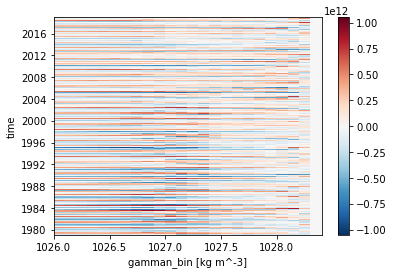

In [117]:
dMdt.plot()

/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':
/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/aos/graemem/miniconda3/envs/so_decadal_variability/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDepreca

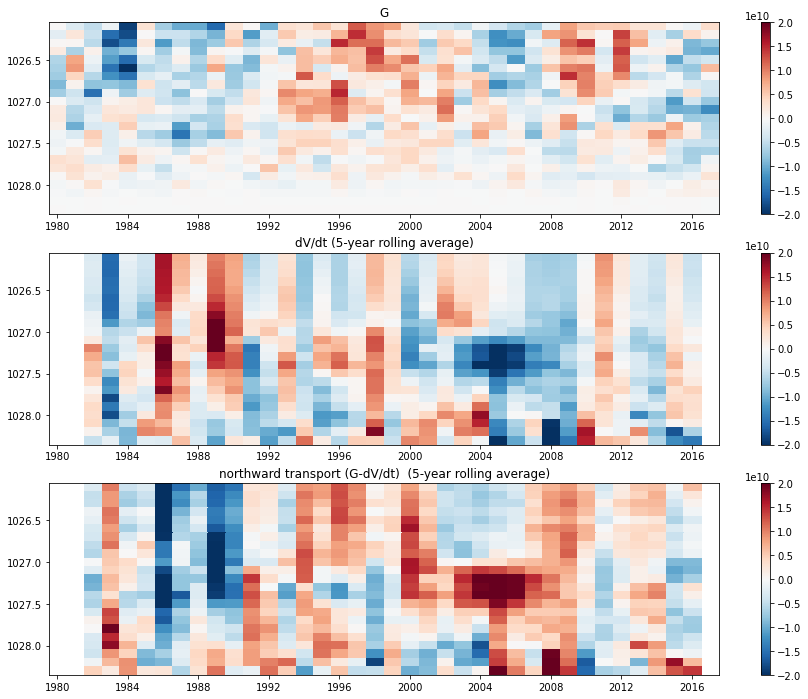

In [119]:
# Compare annual anomalies in G and dMdt
G_annualanom = calc_annualanom(G['total'])
dMdt_annualanom = calc_annualanom(dMdt)
overturning = G_annualanom - dMdt_annualanom

fig,ax = plt.subplots(figsize=(15,12),nrows=3)

im = ax[0].pcolormesh(
    G_annualanom.time,
    G_annualanom.gamman_bin,
    G_annualanom.transpose(),
    cmap='RdBu_r',vmin=-20E9,vmax=20E9)
ax[0].set_title('G')
ax[0].invert_yaxis()
plt.colorbar(im,ax=ax[0]);

im = ax[1].pcolormesh(
    dMdt_annualanom.time,
    dMdt_annualanom.gamman_bin,
    dMdt_annualanom.rolling(time=5,center=True).mean().transpose(),
    cmap='RdBu_r',vmin=-20E9,vmax=20E9)
ax[1].set_title('dV/dt (5-year rolling average)')
ax[1].invert_yaxis()
plt.colorbar(im,ax=ax[1]);

im = ax[2].pcolormesh(
    dMdt_annualanom.time,
    dMdt_annualanom.gamman_bin,
    overturning.rolling(time=5,center=True).mean().transpose(),
    cmap='RdBu_r',vmin=-20E9,vmax=20E9)
ax[2].set_title('northward transport (G-dV/dt)  (5-year rolling average)')
ax[2].invert_yaxis()
plt.colorbar(im,ax=ax[2]);